In [13]:
# pandas for data loading, manipulation etc.
import pandas as pd


# numeric functions
import xgboost
import numpy as np
import collections
import math
import operator
from scipy import stats
from math import ceil
import time
import random as rnd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline


# modelling
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet,Lars,LassoLars,SGDRegressor
from sklearn.linear_model import RidgeCV, LassoCV,BayesianRidge, LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,train_test_split
from sklearn.metrics import make_scorer,r2_score,mean_squared_error,roc_auc_score, accuracy_score,explained_variance_score
from sklearn.neighbors import KNeighborsRegressor #,KNearestNeighborsRegressor


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures, minmax_scale
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE,SelectFromModel
from statsmodels.formula.api import poisson, negativebinomial

import xgboost as xgb
from xgboost import XGBRegressor

import warnings
#warnings.filterwarnings("ignore")

In [2]:
datos = pd.read_csv('datacountstudents.csv')
datos = datos.iloc[:,1:]
# prepare for modeling
X = datos.drop(['yC'], axis=1)
Y = datos['yC'].values

In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 33 columns):
yC     150 non-null int64
x1     150 non-null float64
x2     150 non-null float64
x3     150 non-null int64
x4     150 non-null int64
x5     150 non-null int64
x6     150 non-null int64
x7     150 non-null int64
x8     150 non-null float64
x9     150 non-null int64
x10    150 non-null float64
x11    150 non-null float64
x12    150 non-null float64
x13    150 non-null int64
x14    150 non-null int64
x15    150 non-null int64
x16    150 non-null int64
x17    150 non-null int64
x18    150 non-null int64
x19    150 non-null int64
x20    150 non-null int64
x21    150 non-null float64
x22    150 non-null float64
x23    150 non-null float64
x24    150 non-null float64
x25    150 non-null int64
x26    150 non-null int64
x27    150 non-null float64
x28    150 non-null int64
x29    150 non-null int64
x30    150 non-null int64
x31    150 non-null float64
x32    150 non-null float64
dtypes: flo

In [4]:
#Cambiar las discretas con valores diferentes a o 0 a continuas
datos = pd.read_csv('datacountstudents.csv', dtype={'x9':float,'x25':float,'x26':float,'x30':float})
datos = datos.iloc[:,1:]

In [5]:
X = datos.drop(['yC'], axis=1)
y = datos['yC'].values
# prepare for modeling

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

In [6]:
#nombres columnas continuas
train_C = X_train.select_dtypes(exclude=['int64'])
#train_D= X_train.select_dtypes(exclude=['float'
Columns_C = X_train.columns[(X_train.dtypes.values == np.dtype('float64'))]
#Columns_D = X_train.columns[(X_train.dtypes.values != np.dtype('float64'))]
# Estandarizar solo continuas en train
X_train_sc = X_train.copy()
col_names = Columns_C[0:13]
features_tr = X_train_sc[col_names]
scaler = StandardScaler().fit(features_tr.values)
features_tr = scaler.transform(features_tr.values)
X_train_sc[col_names] = features_tr
# Estandarizar solo continuas en test
X_test_sc = X_test.copy()
features_ts = X_test_sc[col_names]
features_ts = scaler.transform(features_ts.values)
X_test_sc[col_names] = features_ts
#dataframes
X_train_sc = pd.concat([X_train_sc], axis=1, sort=False)
X_test_sc = pd.concat([X_test_sc], axis=1, sort=False)
#X_train_sc.head()

In [7]:
train_x=X_train_sc
train_y=y_train   
Xts = X_test_sc
Yt = y_test

In [8]:
#for tuning parameters
parameters_for_testing = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[2,3,5],
    'n_estimators':[10000],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.4,0.6,0.95]  
}

#https://www.datacamp.com/community/tutorials/xgboost-in-python borrar

In [9]:
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=10, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(train_x,train_y)
print (gsearch1.scorer_ ) # print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

Fitting 3 folds for each of 5832 candidates, totalling 17496 fits


C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   26.2s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   26.6s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   51.5s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 101 tas

[Parallel(n_jobs=6)]: Done 8700 tasks      | elapsed: 436.3min
[Parallel(n_jobs=6)]: Done 8833 tasks      | elapsed: 443.5min
[Parallel(n_jobs=6)]: Done 8966 tasks      | elapsed: 450.4min
[Parallel(n_jobs=6)]: Done 9101 tasks      | elapsed: 459.9min
[Parallel(n_jobs=6)]: Done 9236 tasks      | elapsed: 470.8min
[Parallel(n_jobs=6)]: Done 9373 tasks      | elapsed: 485.0min
[Parallel(n_jobs=6)]: Done 9510 tasks      | elapsed: 494.8min
[Parallel(n_jobs=6)]: Done 9649 tasks      | elapsed: 503.5min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 513.2min
[Parallel(n_jobs=6)]: Done 9929 tasks      | elapsed: 523.9min
[Parallel(n_jobs=6)]: Done 10070 tasks      | elapsed: 540.2min
[Parallel(n_jobs=6)]: Done 10213 tasks      | elapsed: 552.2min
[Parallel(n_jobs=6)]: Done 10356 tasks      | elapsed: 560.8min
[Parallel(n_jobs=6)]: Done 10501 tasks      | elapsed: 571.2min
[Parallel(n_jobs=6)]: Done 10646 tasks      | elapsed: 585.7min
[Parallel(n_jobs=6)]: Done 10793 tasks      | elap

[13:38:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
make_scorer(mean_squared_error, greater_is_better=False)
best params
{'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 10000, 'reg_alpha': 0.75, 'reg_lambda': 1e-05, 'subsample': 0.95}
best score
-1.2830386550580333


In [9]:
data_dmatrix = xgb.DMatrix(data=X_train_sc,label=y_train)
params ={'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 10000, 'reg_alpha': 0.75, 'reg_lambda': 1e-05, 'subsample': 0.95}

In [10]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

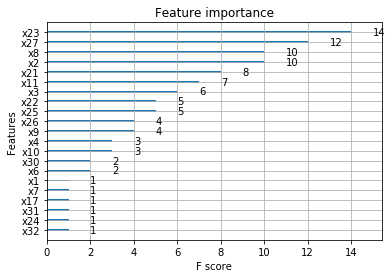

In [11]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [14]:
xg_reg = xgb.XGBRegressor(objective ='count:poisson')
columns=['x23','x27','x2','x11','x22','x25','x26','x4','x10','x1']
X_train_sc3=pd.DataFrame(X_train_sc,columns=columns)
X_test_sc3=pd.DataFrame(X_test_sc,columns=columns)

#Fit the model
xg_reg.fit(X_train_sc3,y_train)
#Make model predictions
preds = xg_reg.predict(X_test_sc3)
y_ts = pd.DataFrame(y_test,columns=['y_ts'])
pred= pd.DataFrame(np.round(preds),columns=['predict'])
#pred
columns=['y_ts','pred']
#dataframe y_test Vs Y_predict
Result1= pd.concat([y_ts,pred], axis=1, sort=False)
Result1['xg_reg_1']= [0]*len(Result1)
sum=0
for i in range(len(Result1)):
    if Result1.predict[i]<=0:
        if Result1.y_ts[i]<=0:
            Result1['xg_reg_1'][i]=1
            sum=sum+1
        else: Result1['xg_reg_1'] [i]=0
    elif Result1.predict[i]>0:
        if Result1.y_ts[i]>0:
            Result1['xg_reg_1'][i]=1
            sum=sum+1        
    else: Result1['xg_reg_1'] [i]=0
print("Explained_variance_score: ",explained_variance_score(y_test,pred))
print("Test 0 y >0: ",sum/len(Result1))
print("MSE_test:",np.sqrt(mean_squared_error(y_test, pred)))

C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Explained_variance_score:  -0.11066931742876074
Test 0 y >0:  0.7333333333333333
MSE_test: 1.3662601021279464


In [15]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [16]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.473454,0.087722,1.506747,0.185688
1,1.397152,0.088540,1.466915,0.186004
2,1.324203,0.083385,1.437171,0.185742
3,1.259634,0.083965,1.408128,0.189962
4,1.198986,0.083101,1.373504,0.196429


In [17]:
print((cv_results["test-rmse-mean"]).tail(5))

12    1.258525
13    1.253163
14    1.248536
15    1.239866
16    1.232256
Name: test-rmse-mean, dtype: float64


In [18]:
y_ts = pd.DataFrame(y_test,columns=['y_ts'])
pred= pd.DataFrame(np.round(preds),columns=['predict'])
#pred
columns=['y_ts','pred']# X_train_sc,label=y_train
Result = pd.concat([y_ts,pred], axis=1, sort=False)

In [19]:
Result = pd.concat([y_ts,pred], axis=1, sort=False)
Result

,y_ts,predict
0,0,1.0
1,2,4.0
2,1,0.0
3,5,2.0
4,2,1.0
5,0,1.0
6,3,4.0
7,0,2.0
8,4,2.0
9,0,0.0


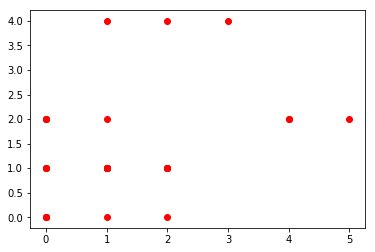

In [20]:
plt.scatter(y_test, np.round(preds), color = 'red')

In [21]:
#Train Dataframe
#To erase index of X_train
X_train_sc2=X_train_sc.reset_index().values
#y_train as a dataframe
y_train2= pd.DataFrame(y_train,columns=['y_train'])
columns=['id','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19',
         'x20','x21','x22','x23','x24','x25','x26','x27','x28', 'x29', 'x30', 'x31','x32']
#change name of colums of X_train
X_train_sc2= pd.DataFrame(X_train_sc2,columns=columns)#
#drop id
X_train_sc2=X_train_sc2.drop(['id'], axis=1)
#Dataframe y with x's
X_train_sc2 = pd.concat([y_train2,X_train_sc2], axis=1, sort=False)

# Test DataFrame
X_test_sc2=X_test_sc.reset_index().values
y_test2= pd.DataFrame(y_test,columns=['y_test'])
X_test_sc2= pd.DataFrame(X_test_sc2,columns=columns)
X_test_sc2=X_test_sc2.drop(['id'], axis=1)
X_test_sc2 = pd.concat([y_test2,X_test_sc2], axis=1, sort=False)

In [22]:
m1 = poisson('y_train2~x23+x27+x2+x11+x22+x25+x26+x4+x10+x1', data = X_train_sc2).fit()
print (m1.summary())

Optimization terminated successfully.
         Current function value: 1.340558
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:               y_train2   No. Observations:                  120
Model:                        Poisson   Df Residuals:                      109
Method:                           MLE   Df Model:                           10
Date:                Wed, 02 Oct 2019   Pseudo R-squ.:                  0.1408
Time:                        14:15:39   Log-Likelihood:                -160.87
converged:                       True   LL-Null:                       -187.22
                                        LLR p-value:                 8.440e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3844      0.196      1.960      0.050   -5.37e-05       0.769
x23            0.0683      0.

In [23]:
#model_fit1 = X_test_sc
preds_2 = m1.predict(X_test_sc)
preds_2=preds_2.reset_index().values
y_test2 = pd.DataFrame(y_test,columns=['y_ts'])
pred2= pd.DataFrame(preds_2,columns=['id','pred1'])
Result2 = pd.concat([y_test2,np.round(pred2.iloc[:,1])], axis=1, sort=False)
Result2

,y_ts,pred1
0,0,1.0
1,2,5.0
2,1,1.0
3,5,2.0
4,2,2.0
5,0,1.0
6,3,3.0
7,0,3.0
8,4,2.0
9,0,2.0


C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Val 0 y >0:  0.7666666666666667
Predicted  0   1
Actual          
0          2   0
1          7  21


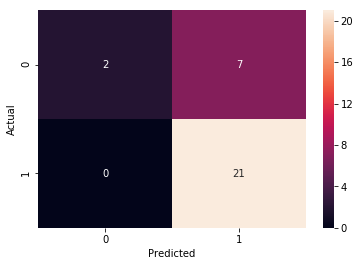

In [24]:
Result2['Mayor0_test'] = (Result2['pred1']>0).astype(int)
Result2['Mayor0_real'] = (Result2['y_ts']>0).astype(int)
Result2['prueba']= [0]*len(Result2['Mayor0_real'])
sum=0
for i in range(len(Result2['Mayor0_real'])):
    if Result2.Mayor0_real[i]==Result2.Mayor0_test[i]:
        Result2['prueba'][i]=1
        sum=sum+1
    else: Result2['prueba'] [i]=0
accu=sum/len(Result2['Mayor0_real'])
print("Val 0 y >0: ",accu)
confusion_matrix = pd.crosstab(Result2['Mayor0_test'],Result2['Mayor0_real'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
df = pd.DataFrame(Result2, columns=['Mayor0_test','Mayor0_real'])
confusion_matrix = pd.crosstab(df['Mayor0_real'], df['Mayor0_test'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)

In [25]:
m_nb = negativebinomial('y_train2~x23+x27+x2+x11+x22+x25+x26+x4+x10+x1', data = X_train_sc2).fit()
print (m_nb.summary())

         Current function value: 1.340558
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42
                     NegativeBinomial Regression Results                      
Dep. Variable:               y_train2   No. Observations:                  120
Model:               NegativeBinomial   Df Residuals:                      109
Method:                           MLE   Df Model:                           10
Date:                Wed, 02 Oct 2019   Pseudo R-squ.:                  0.1263
Time:                        14:15:58   Log-Likelihood:                -160.87
converged:                      False   LL-Null:                       -184.13
                                        LLR p-value:                 1.153e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3845        nan        nan        nan         nan         n

C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid 

In [26]:
preds_3 = m_nb.predict(X_test_sc)
preds_3=preds_3.reset_index().values
pred3= pd.DataFrame(preds_3,columns=['id','pred1'])
y_test3 = pd.DataFrame(y_test,columns=['y_ts'])
Result3 = pd.concat([y_test3,np.round(pred3.iloc[:,1])], axis=1, sort=False)
Result3

,y_ts,pred1
0,0,1.0
1,2,5.0
2,1,1.0
3,5,2.0
4,2,2.0
5,0,1.0
6,3,3.0
7,0,3.0
8,4,2.0
9,0,2.0


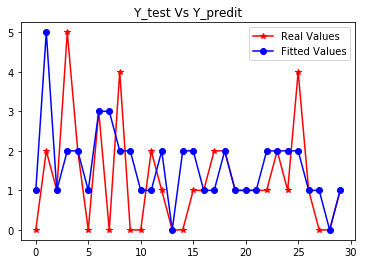

In [27]:
preds = np.round(pred2.iloc[:,1])
plt.plot(range(len(y_test3)), y_test3, 'r*-', range(len(y_test3)), preds, 'bo-')
plt.title('Y_test Vs Y_predit')
plt.legend(['Real Values', 'Fitted Values'])
plt.show()

C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Val 0 y >0:  0.7666666666666667
Predicted  0   1
Actual          
0          2   0
1          7  21


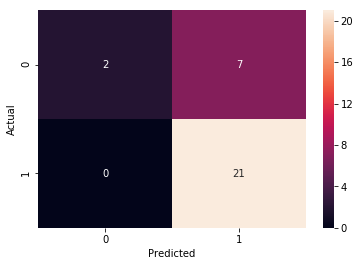

In [28]:
Result3['Mayor0_test'] = (Result3['pred1']>0).astype(int)
Result3['Mayor0_real'] = (Result3['y_ts']>0).astype(int)
Result3['prueba']= [0]*len(Result3['Mayor0_real'])
sum=0
for i in range(len(Result3['Mayor0_real'])):
    if Result3.Mayor0_real[i]==Result3.Mayor0_test[i]:
        Result3['prueba'][i]=1
        sum=sum+1
    else: Result3['prueba'] [i]=0
accu=sum/len(Result3['Mayor0_real'])
print("Val 0 y >0: ",accu)
confusion_matrix = pd.crosstab(Result3['Mayor0_test'],Result3['Mayor0_real'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
df = pd.DataFrame(Result3, columns=['Mayor0_test','Mayor0_real'])
confusion_matrix = pd.crosstab(df['Mayor0_real'], df['Mayor0_test'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)

https://jbhender.github.io/Stats506/F17/Projects/Poisson_Regression.html borrar